In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
validate = pd.read_csv('validate.csv')

In [3]:
columnsOfInterest = ['roa', 'intcov_ratio', 'quick_ratio', 'intcov', 'bm', 'npm', 'debt_assets', 'debt_ebitda', 'inv_turn', 'cash_ratio']
yTrain = train['rating']
xTrain = train[columnsOfInterest]

yTest = test['rating']
xTest = test[columnsOfInterest]

yValidate = validate['rating']
xValidate = validate[columnsOfInterest]

In [4]:
#Reconstruct original data from train, test, and validate
df = pd.concat([xTrain, xTest, xValidate])

Text(0.5, 1.0, 'Correlation Heatmap')

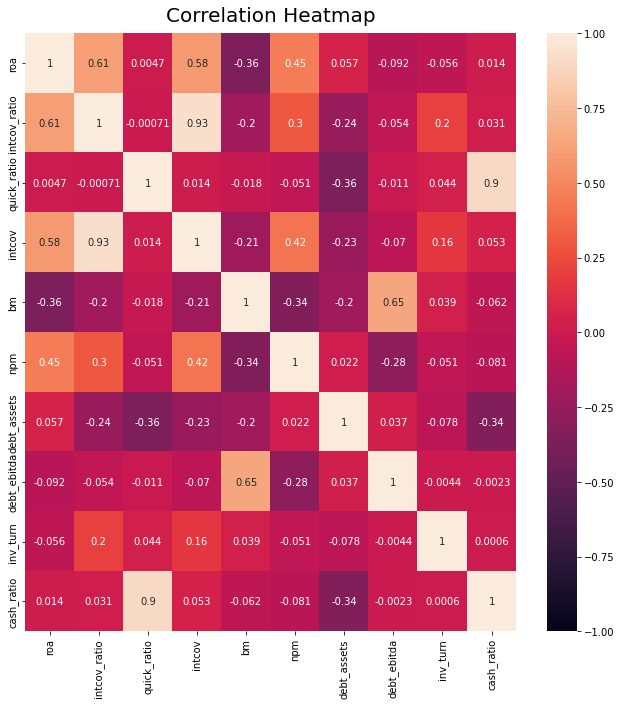

In [5]:
corr = df[columnsOfInterest].corr()
plt.figure(figsize=(11, 11))
heatmap = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

In [6]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)
xValidate = scaler.transform(xValidate)


# Use lasso regularization to select features
from sklearn.linear_model import LassoCV


# Fit the model
clf = LassoCV().fit(xTrain, yTrain)


# Print names of non-zero coefficients
selectedFeatures = []
print("Columns selected are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] != 0:
        print(columnsOfInterest[i])
        selectedFeatures.append(i)

print("\n\nColumns dropped are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] == 0:
        print(columnsOfInterest[i])

Columns selected are : 
intcov_ratio
quick_ratio
bm
npm
debt_assets
inv_turn
cash_ratio


Columns dropped are : 
roa
intcov
debt_ebitda


In [7]:
#Get only selected features
xTrain = xTrain[:,selectedFeatures]
xTest = xTest[:,selectedFeatures] 
xValidate = xValidate[:,selectedFeatures]
#Set up a dictionary to store the accuracy for different values of k
knn_results = {}
#Loop through a variety of values for k number of neighbors
for k in range(1,26):
    #Make the KNN model with k neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    #Fit the model to the training data
    knn.fit(xTrain,yTrain)
    knn.predict(xValidate)
    #Store the accuracy of the model for each k value
    knn_results[k] = knn.score(xValidate,yValidate)

Text(0.5, 1.0, 'Validation Accuracy vs. Value of k')

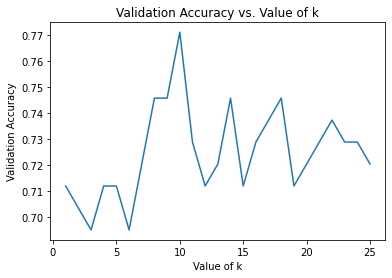

In [8]:
#Plot the accuracy for each k value
plt.plot(knn_results.keys(),knn_results.values())
plt.xlabel('Value of k')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Value of k')

In [9]:
knn_final = KNeighborsClassifier(n_neighbors = 9)
knn_final.fit(xTrain,yTrain)
knn_final_pred = knn_final.predict(xTest)
knn_final.score(xTest,yTest)

0.7033898305084746

In [10]:
#Make a function that automatically generates a clean looking confusion matrix
def create_confusion_matrix(test_vals, pred_vals, model_name):
    conf_mat = confusion_matrix(test_vals, pred_vals)
    sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
                fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    #Change the 0's and 1's to the actual class names for clearer interpretation
    plt.xticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.yticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.title('Confusion Matrix for {} Model'.format(model_name))

In [11]:
#Make a function that automatically generates a clean looking ROC curve
def create_roc_curve(model, x_test, y_test, model_name):
    metrics.plot_roc_curve(model, x_test, y_test, name=model_name)
    #Add baseline classifier line
    plt.plot([0,1],[0,1], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

In [12]:
#Make a function that automatically generates a clean looking ROC curve
def create_pr_curve(model, x_test, y_test, model_name):
    metrics.plot_precision_recall_curve(model, x_test, y_test, name=model_name)
    #Add baseline classifier line at positive rate 
    positive_rate = sum(y_test)/len(y_test)
    plt.plot([0,1],[positive_rate,positive_rate], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


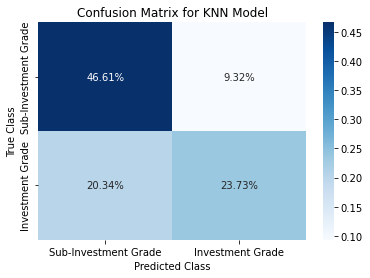

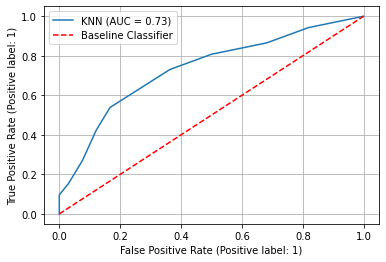

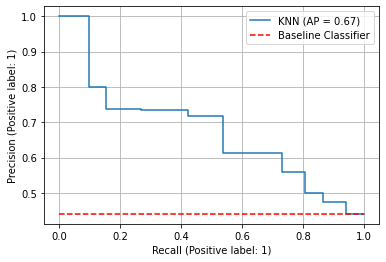

In [13]:
create_confusion_matrix(yTest, knn_final_pred,'KNN')
create_roc_curve(knn_final, xTest, yTest, 'KNN')
create_pr_curve(knn_final, xTest, yTest, 'KNN')

In [14]:
#Fit a basic decision tree model
tree_mod = DecisionTreeClassifier(max_depth=3,random_state=1)
tree_mod.fit(xTrain,yTrain)
tree_mod_pred = tree_mod.predict(xTest)
tree_mod.score(xTest,yTest)

0.711864406779661

C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


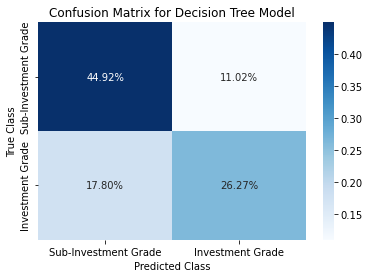

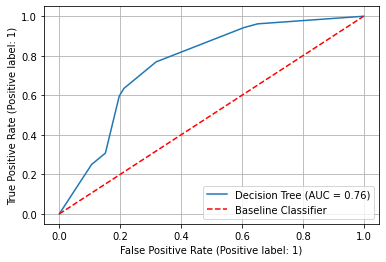

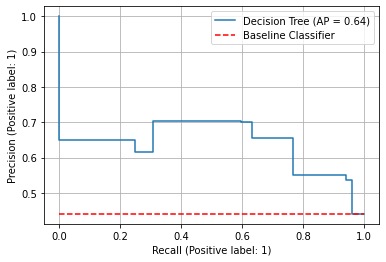

In [15]:
create_confusion_matrix(yTest, tree_mod_pred,'Decision Tree')
create_roc_curve(tree_mod, xTest, yTest, 'Decision Tree')
create_pr_curve(tree_mod, xTest, yTest, 'Decision Tree')

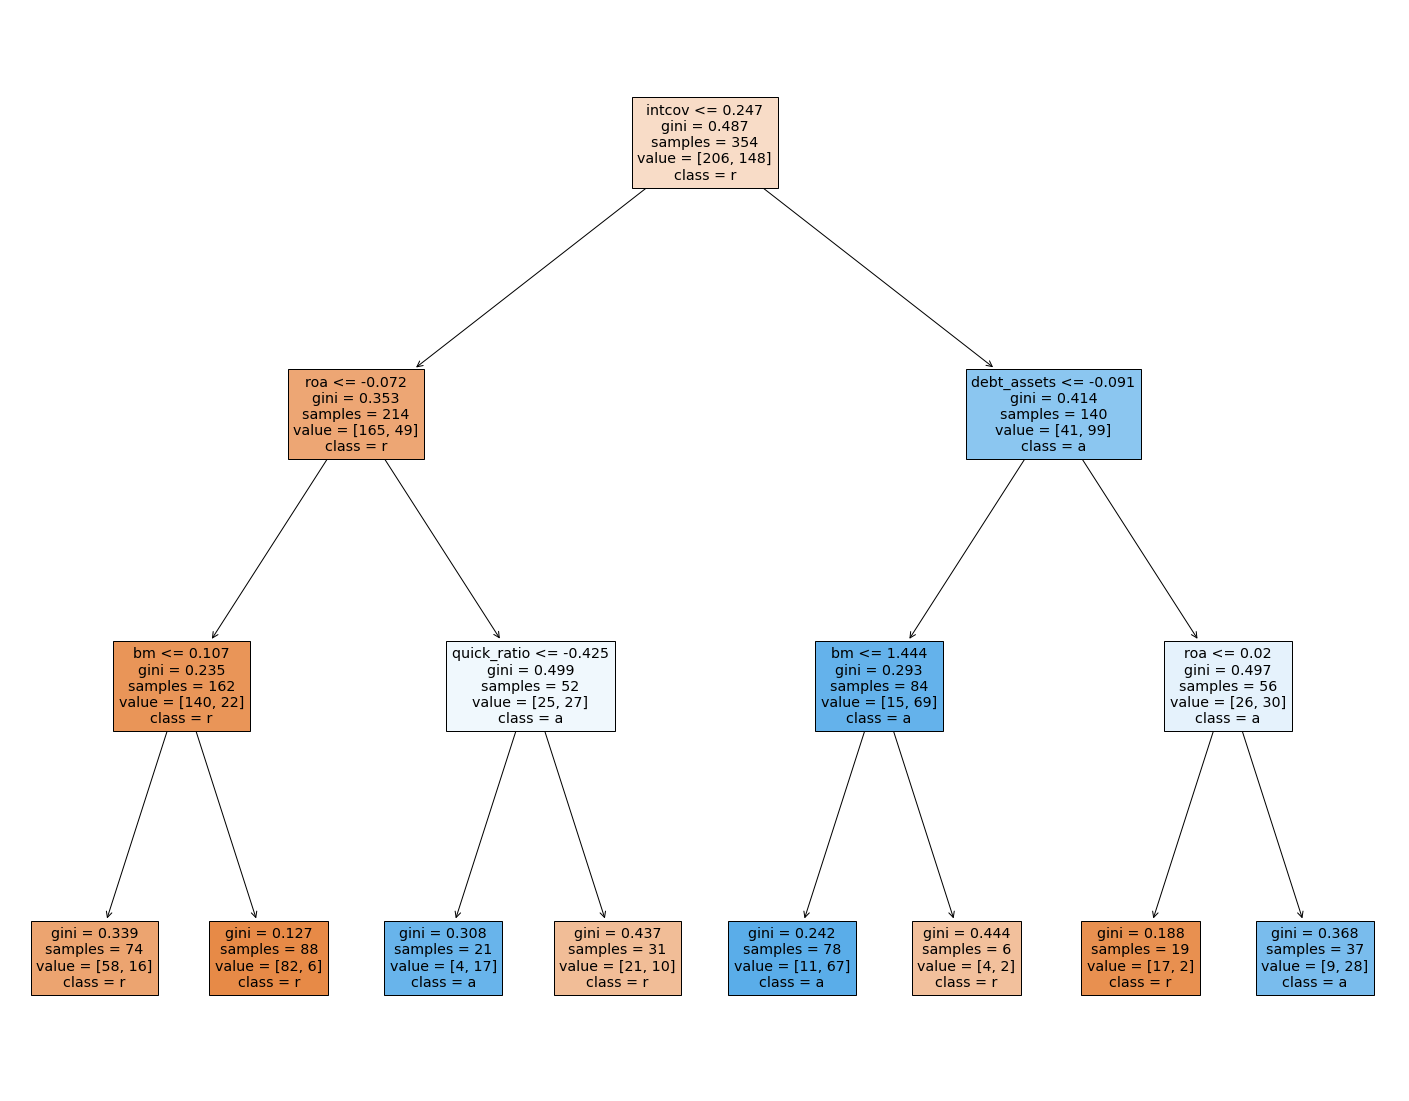

In [16]:
#Visualize the decision tree model from above
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_mod, 
                   feature_names=columnsOfInterest,  
                   class_names='rating',
                   filled=True)

In [17]:
n_estimators = [100,150,200,250,300] 
max_depth = [2,3,4,5,6] 
grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rf_mod_tuned = RandomForestClassifier(random_state=1)
#Since we're doing cross validation, combine the training and validation data
xTrainValidate = np.concatenate((xTrain,xValidate))
yTrainValidate = np.concatenate((yTrain,yValidate))
rf_mod_tuned = GridSearchCV(estimator = rf_mod_tuned, param_grid = grid,
               cv = 5, verbose=2, n_jobs = -1)
rf_mod_tuned_fitted = rf_mod_tuned.fit(xTrainValidate,yTrainValidate)
rf_mod_tuned_pred = rf_mod_tuned_fitted.predict(xTest)
rf_mod_tuned_fitted.score(xTest,yTest)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


0.7711864406779662

In [18]:
rf_mod_tuned.best_params_

{'max_depth': 5, 'n_estimators': 100}

C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


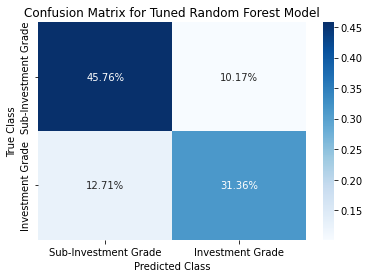

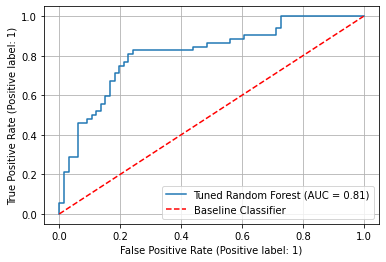

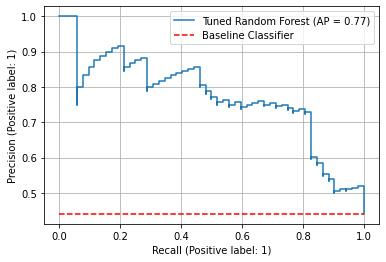

In [19]:
create_confusion_matrix(yTest, rf_mod_tuned_pred,'Tuned Random Forest')
create_roc_curve(rf_mod_tuned_fitted, xTest, yTest, 'Tuned Random Forest')
create_pr_curve(rf_mod_tuned_fitted, xTest, yTest, 'Tuned Random Forest')

Text(0.5, 1.0, 'Feature Importance vs. Feature')

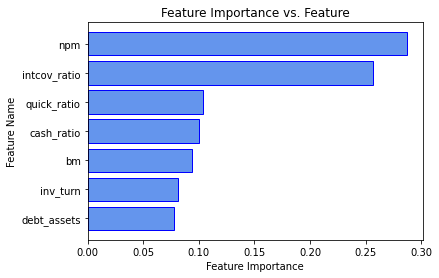

In [31]:
imp_scores = rf_mod_tuned_fitted.best_estimator_.feature_importances_
#Plot feature importances vs selected features
selectedFeatures_names = [columnsOfInterest[i] for i in selectedFeatures]
sorted_idx = imp_scores.argsort()
plt.barh([selectedFeatures_names[i] for i in sorted_idx],imp_scores[sorted_idx],color='cornflowerblue',edgecolor='blue')
#fill bar with color
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance vs. Feature')